In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

print("--- Starting LSTM Model ---")

# =================================================================
# 1. LOAD THE MASTER, CLEANED DATASET
# =================================================================
df = pd.read_csv('../data/processed/model_ready_data.csv', index_col='date', parse_dates=True)

# =================================================================
# 2. DEFINE FEATURES (X) AND TARGET (y)
# =================================================================
y = df['target_discharge_t+7']
X = df.drop(columns=['discharge', 'target_discharge_t+7'])

# =================================================================
# 3. SPLIT DATA INTO TRAINING AND TESTING SETS
# =================================================================
split_date = '2005-01-01'
X_train = X.loc[X.index < split_date]
y_train = y.loc[y.index < split_date]
X_test = X.loc[X.index >= split_date]
y_test = y.loc[y.index >= split_date]

# =================================================================
# 4. SCALE THE DATA
# =================================================================
# Initialize the scaler. This will scale all values to be between 0 and 1.
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scaler on the TRAINING data only and transform it
X_train_scaled = scaler_X.fit_transform(X_train)

# Use the same scaler to transform the TEST data
X_test_scaled = scaler_X.transform(X_test)

# Scale the target variable (y) separately
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


print("✅ Data successfully loaded, split, and scaled.")
print(f"Shape of scaled training features: {X_train_scaled.shape}")
print(f"Shape of scaled testing features: {X_test_scaled.shape}")

--- Starting LSTM Model ---
✅ Data successfully loaded, split, and scaled.
Shape of scaled training features: (8737, 19)
Shape of scaled testing features: (782, 19)


In [5]:
# =================================================================
# 5. RESHAPE DATA INTO SEQUENCES (3D Tensors)
# =================================================================

def create_sequences(X, y, sequence_length=30):
    """
    This function takes our 2D feature and target arrays and converts them
    into 3D sequences that the LSTM can understand.
    """
    X_sequences, y_sequences = [], []
    for i in range(len(X) - sequence_length):
        X_sequences.append(X[i:i+sequence_length])
        y_sequences.append(y[i+sequence_length])
    return np.array(X_sequences), np.array(y_sequences)

# Define the sequence length (e.g., use the last 30 days to predict the future)
SEQUENCE_LENGTH = 30

# Create the sequences for the training and testing sets
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQUENCE_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, SEQUENCE_LENGTH)

print("✅ Data successfully reshaped into sequences.")
print(f"Shape of training sequences (X): {X_train_seq.shape}")
print(f"Shape of training targets (y): {y_train_seq.shape}")
print(f"Shape of testing sequences (X): {X_test_seq.shape}")
print(f"Shape of testing targets (y): {y_test_seq.shape}")

✅ Data successfully reshaped into sequences.
Shape of training sequences (X): (8707, 30, 19)
Shape of training targets (y): (8707, 1)
Shape of testing sequences (X): (752, 30, 19)
Shape of testing targets (y): (752, 1)


In [6]:
!pip install tensorflow

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# =================================================================
# 6. DESIGN AND BUILD THE LSTM MODEL ARCHITECTURE
# =================================================================

# Initialize the neural network
model_lstm = Sequential()

# Add the first LSTM layer
# 'input_shape' tells the model the shape of our sequences (30 timesteps, 19 features)
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
model_lstm.add(Dropout(0.2))

# Add a second LSTM layer
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))

# Add the final Dense output layer
model_lstm.add(Dense(units=1))


# =================================================================
# 7. COMPILE THE MODEL
# =================================================================
# 'compile' configures the model for training.
# 'optimizer='adam'' is an efficient algorithm for finding the best model weights.
# 'loss='mean_squared_error'' tells the model to minimize the squared error during training.
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Print a summary of our model's architecture
model_lstm.summary()

C:\Users\dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          14,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,251 (133.79 KB)

 Trainable params: 34,251 (133.79 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# =================================================================
# 8. TRAIN THE LSTM MODEL
# =================================================================

print("Starting model training... This will take a while.")

# history will store the training progress for later visualization
history = model_lstm.fit(
    X_train_seq,
    y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2, # Use 20% of training data for validation
    verbose=1 # This will print the progress for each epoch
)

print("\n✅ Model training complete!")

Starting model training... This will take a while.
Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0143 - val_loss: 0.0069
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0086 - val_loss: 0.0059
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0077 - val_loss: 0.0057
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0072 - val_loss: 0.0055
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0068 - val_loss: 0.0058
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0066 - val_loss: 0.0053
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 9/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0060 - val_loss: 0.0049
Epoch 10/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0058 - val_loss: 0.0053
Epoch 11/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0058 - val_los

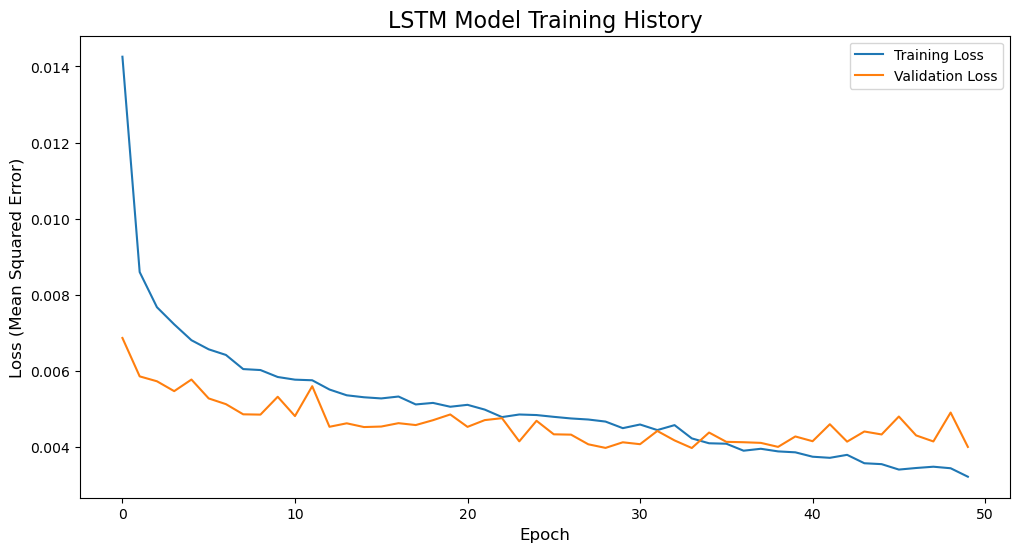

In [10]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Training History', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (Mean Squared Error)', fontsize=12)
plt.legend()
plt.show()

In [10]:
import numpy as np
import hydroeval as he
# --- Add these missing imports ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# =================================================================
# 10. FINAL EVALUATION
# =================================================================

# Calculate the metrics
rmse = np.sqrt(mean_squared_error(results_lstm['Observed'], results_lstm['Predicted_LSTM']))
mae = mean_absolute_error(results_lstm['Observed'], results_lstm['Predicted_LSTM'])
r2 = r2_score(results_lstm['Observed'], results_lstm['Predicted_LSTM'])
nse = he.evaluator(he.nse, results_lstm['Predicted_LSTM'], results_lstm['Observed'])[0]

# Print the results
print("\n--- LSTM Model Performance Metrics ---")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} m³/s")
print(f"Mean Absolute Error (MAE): {mae:.2f} m³/s")
print(f"R-squared (R²): {r2:.2f}")
print(f"Nash-Sutcliffe Efficiency (NSE): {nse:.2f}")

print("\n--- Baseline MLR Performance (for comparison) ---")
print("RMSE: 132.81 m³/s")
print("NSE: 0.73")


--- LSTM Model Performance Metrics ---
Root Mean Square Error (RMSE): 125.36 m³/s
Mean Absolute Error (MAE): 71.95 m³/s
R-squared (R²): 0.76
Nash-Sutcliffe Efficiency (NSE): 0.76

--- Baseline MLR Performance (for comparison) ---
RMSE: 132.81 m³/s
NSE: 0.73


In [11]:
import hydroeval as he

# Calculate the metrics
rmse = np.sqrt(mean_squared_error(results_lstm['Observed'], results_lstm['Predicted_LSTM']))
mae = mean_absolute_error(results_lstm['Observed'], results_lstm['Predicted_LSTM'])
r2 = r2_score(results_lstm['Observed'], results_lstm['Predicted_LSTM'])
nse = he.evaluator(he.nse, results_lstm['Predicted_LSTM'], results_lstm['Observed'])[0]

# Print the results
print("\n--- LSTM Model Performance Metrics ---")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} m³/s")
print(f"Mean Absolute Error (MAE): {mae:.2f} m³/s")
print(f"R-squared (R²): {r2:.2f}")
print(f"Nash-Sutcliffe Efficiency (NSE): {nse:.2f}")

print("\n--- Baseline MLR Performance ---")
print("RMSE: 132.81 m³/s")
print("NSE: 0.73")


--- LSTM Model Performance Metrics ---
Root Mean Square Error (RMSE): 125.36 m³/s
Mean Absolute Error (MAE): 71.95 m³/s
R-squared (R²): 0.76
Nash-Sutcliffe Efficiency (NSE): 0.76

--- Baseline MLR Performance ---
RMSE: 132.81 m³/s
NSE: 0.73


In [12]:
# =================================================================
# 9. MAKE PREDICTIONS ON THE TEST SET
# =================================================================
# Predict the scaled values
y_pred_scaled = model_lstm.predict(X_test_seq)

# Inverse transform the predictions to get them back to original units
y_pred_lstm = scaler_y.inverse_transform(y_pred_scaled)

# Inverse transform the actual test values as well for comparison
y_test_actual = scaler_y.inverse_transform(y_test_seq)

# Create a results DataFrame
# Note: The sequences shorten the data, so we need to align it with the correct dates from the original y_test
results_lstm = pd.DataFrame({
    'Observed': y_test_actual.flatten(),
    'Predicted_LSTM': y_pred_lstm.flatten()
}, index=y_test.index[SEQUENCE_LENGTH:])


print("--- LSTM Model Predictions ---")
print(results_lstm.head())

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step 
--- LSTM Model Predictions ---
            Observed  Predicted_LSTM
date                                
2005-01-31    44.574      -38.466660
2005-02-01    46.324      -36.621067
2005-02-02    53.621      -41.376419
2005-02-03    59.204      -44.348808
2005-02-04    58.273      -36.871674


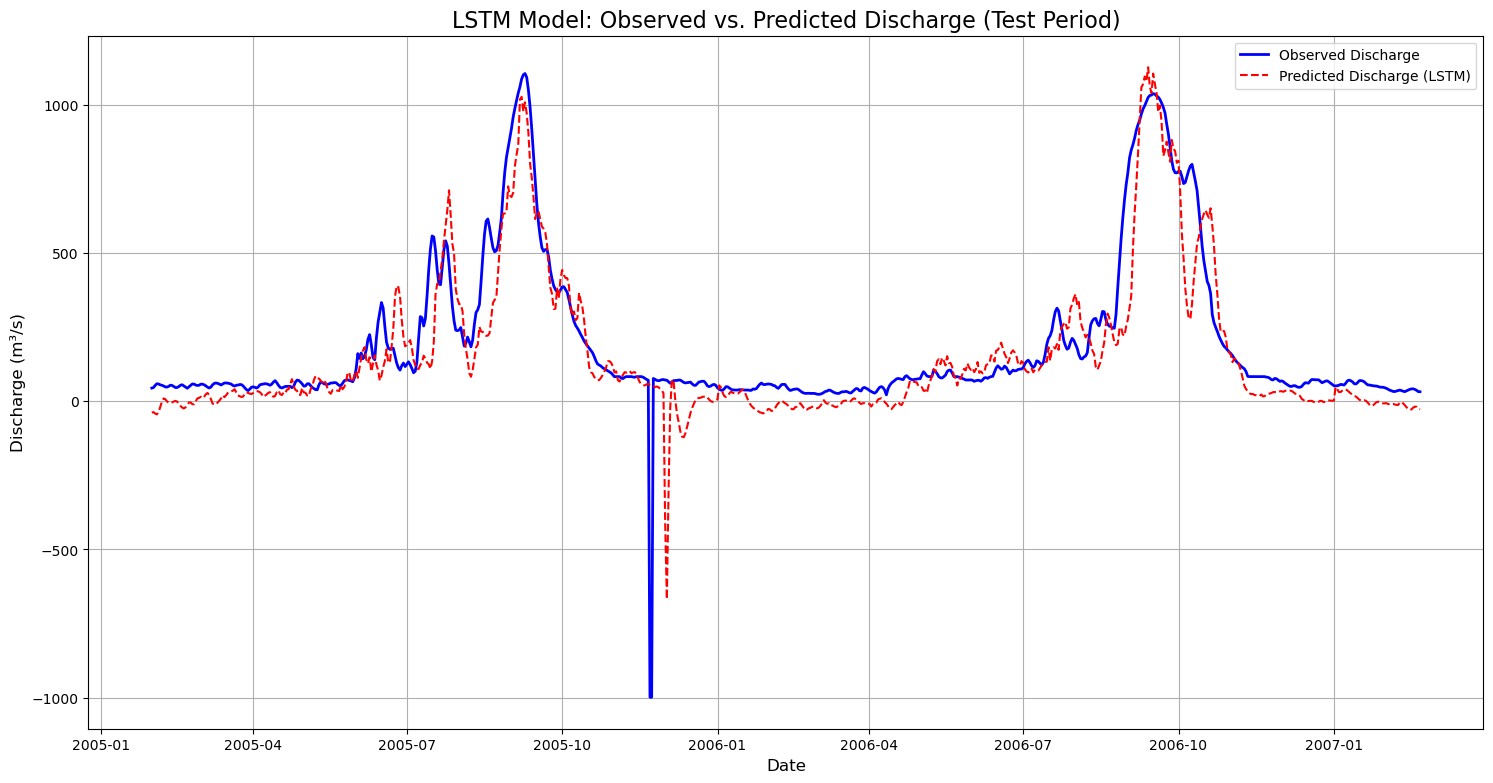

In [13]:
import matplotlib.pyplot as plt

# --- Time-Series Plot ---
plt.figure(figsize=(18, 9))
plt.plot(results_lstm.index, results_lstm['Observed'], label='Observed Discharge', color='blue', linewidth=2)
plt.plot(results_lstm.index, results_lstm['Predicted_LSTM'], label='Predicted Discharge (LSTM)', color='red', linestyle='--')

plt.title('LSTM Model: Observed vs. Predicted Discharge (Test Period)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Discharge (m³/s)', fontsize=12)
plt.legend()
plt.grid(True)

# This line saves the plot to your 'figures' folder
plt.savefig('../figures/lstm_vs_observed_timeseries.png', dpi=300)

plt.show()

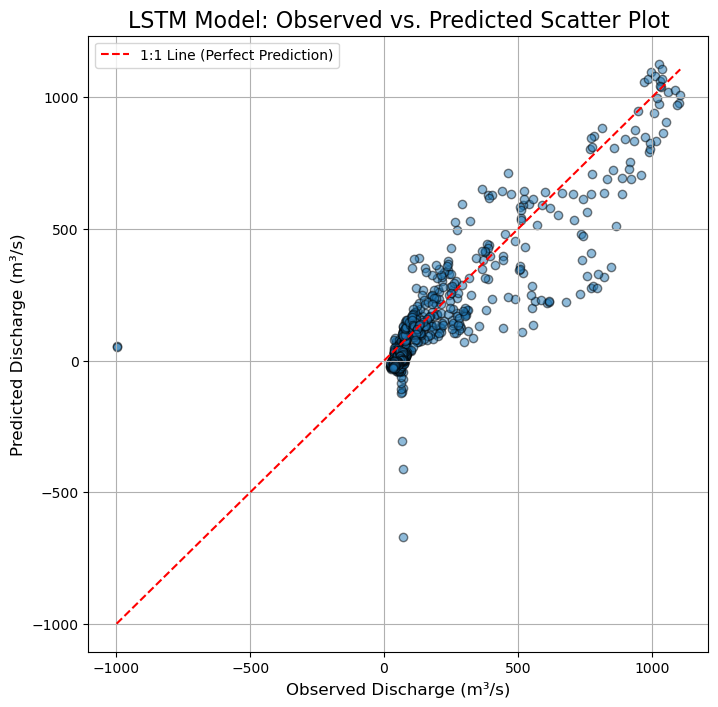

In [14]:
# --- Scatter Plot ---
plt.figure(figsize=(8, 8))
plt.scatter(results_lstm['Observed'], results_lstm['Predicted_LSTM'], alpha=0.5, edgecolors='k')
plt.plot([results_lstm['Observed'].min(), results_lstm['Observed'].max()], 
         [results_lstm['Observed'].min(), results_lstm['Observed'].max()], 
         color='red', linestyle='--', label='1:1 Line (Perfect Prediction)')
         
plt.title('LSTM Model: Observed vs. Predicted Scatter Plot', fontsize=16)
plt.xlabel('Observed Discharge (m³/s)', fontsize=12)
plt.ylabel('Predicted Discharge (m³/s)', fontsize=12)
plt.legend()
plt.grid(True)

# This line saves the plot to your 'figures' folder
plt.savefig('../figures/lstm_scatter_plot.png', dpi=300)

plt.show()

In [15]:
import joblib

# Save the trained LSTM model
model_lstm.save('final_lstm_model.keras')

# Save the scalers
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

print("✅ Model and scalers have been saved!")

✅ Model and scalers have been saved!
